# 4-1. 프로젝트: 뉴스기사 요약해보기

## Step 1. 데이터 수집하기

In [36]:
from nltk.corpus import stopwords # stopwords 불용어
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer # 입력된 훈련 데이터로부터 단어 집합을 만들 수 있음
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('stopwords')
import summa
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

!pip install summa
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas


# 라이브러리 버전 확인
print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.3.3
1.2.0


In [37]:
import urllib.request
# 링크에서 다운로드 받은 데이터
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10) #랜덤한 10개 샘플 출력

,headlines,text
20351,Pandya deserved Man of the Match award as much...,Former India cricketer Sachin Tendulkar has sa...
40821,Lucknow University to introduce a 'purohit' co...,The University of Lucknow has decided to intro...
79006,CBEC slams West Bengal's introduction of e-way...,Central Board of Excise and Customs has critic...
45838,"Robbers steal 25 kg locker, find only one Ã¢Â...",Burglars fled a Bengaluru house with a 25 kg l...
47372,Footballer to donate bone marrow to brother wh...,"Argentine defender Cristian Villagra, who play..."
47859,Japan's economy posts longest growth streak si...,The Japanese economy posted its longest period...
54183,"US foolishly gave billions to Pak, got lies in...",The US has foolishly provided assistance worth...
13221,Google Trends map shows #MeToo movement spread...,A Google Trends data visualisation website cre...
89857,What do Republic TV's 'Sunanda Murder Tapes' r...,According to tapes released by Republic TV ove...
47582,All look same: 5-time Olympian commentator on ...,Commentating during the Winter Olympics in Pye...


## Step 2. 데이터 전처리하기 (추상적 요약)

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [38]:
# 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

#중복 샘플 제거 drop_duplicates()
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98360


In [39]:
print(data.isnull().sum()) # 데이터프레임에 Null 값이 있는지 확인 (데이터프레임에서 Null을 제거할 때는 dropna() 함수 사용)

headlines    0
text         0
dtype: int64


### 텍스트 정규화와 불용어 제거

In [40]:
# 텍스트 정규화와 불용어 제거
# 텍스트 정규화를 위한 사전(dictionary) 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [41]:
# 불용어 제거
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [48]:
# 전체 text 데이터에 대한 전처리
clean_text = []

for sentence in data['text']:
    preprocessed_sentence = preprocess_sentence(sentence)
    clean_text.append(preprocessed_sentence)

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5]) # 상위 5개의 줄을 출력

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [49]:
# 전체 text 데이터에 대한 전처리
clean_headlines = []

for sentence in data['headlines']:
    preprocessed_sentence = preprocess_sentence(sentence, False)  # 불용어를 제거하지 않습니다.
    clean_headlines.append(preprocessed_sentence)

# 전처리 후 출력
print("headlines 전처리 후 결과: ", clean_headlines[:5]) # 상위 5개의 줄을 출력

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [50]:
# 데이터들을 데이터프레임에 재저장
data['text'] = clean_text
data['headlines'] = clean_headlines
# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
# 데이터프레임에 Null 값이 있는지 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [51]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


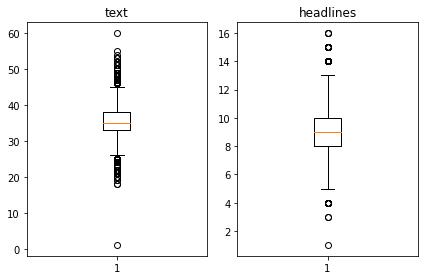

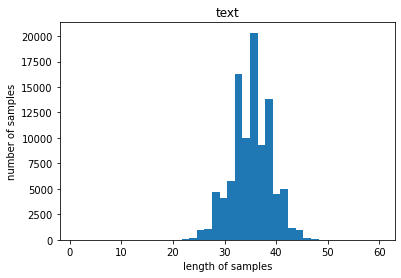

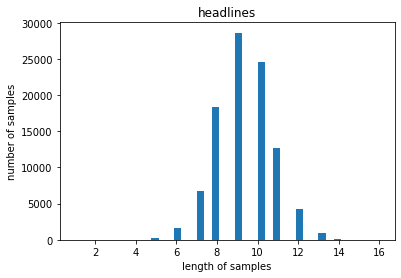

In [53]:
# 길이 분포 시각화
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [70]:
# 최대길이 지정
text_max_len = 37
headlines_max_len = 10

# 데이터의 몇 %가 해당하는지 계산하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

# text와 headlines에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 확인
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 37 이하인 샘플의 비율: 0.7378304188694591
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


In [71]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 58912


### 시작 토큰과 종료 토큰 추가하기

In [73]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...
16,karan johar tabu turn showstoppers on opening ...,filmmaker karan johar actress tabu turned show...,sostoken karan johar tabu turn showstoppers on...,karan johar tabu turn showstoppers on opening ...


In [74]:
# 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 데이터와 테스트 데이터 분리

In [75]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 5576 57573 31394 ... 43589 34033 29933]


In [76]:
# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해서 잘 섞인 샘플을 만든다
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2) # 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 11782


In [77]:
# 정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 47130
훈련 레이블의 개수 : 47130
테스트 데이터의 개수 : 11782
테스트 레이블의 개수 : 11782


### 정수 인코딩

In [79]:
# 단어 집합(vocabulary) 만들기 및 정수 인코딩
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성 
# 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장

In [80]:
threshold = 7 # 등장 빈도수가 7회 미만인 단어
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items(): 
    # src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장 이를 통해서 통계적인 정보를 얻을 수 있음
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 54048
등장 빈도가 6번 이하인 희귀 단어의 수: 37308
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16740
단어 집합에서 희귀 단어의 비율: 69.02753108348135
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.8427501969306075


In [82]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

# 텍스트 시퀀스를 정수 시퀀스로 변환
# texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[18, 27, 1052, 375, 1056, 1280, 1170, 3289, 375, 1404, 1115, 1680, 4456, 34, 1602, 7833, 1336, 2458, 375, 18, 1, 1666, 238, 2941, 104, 839, 375], [1270, 3888, 474, 484, 3592, 559, 858, 2609, 3149, 3290, 968, 3688, 204, 7834, 3841, 1270, 828, 6191, 598, 29, 1421, 1270, 1785, 35, 152, 6, 484, 1023, 462, 42, 3291], [328, 21, 1952, 1303, 50, 1, 368, 697, 312, 403, 33, 143, 448, 135, 110, 368, 1253, 7646, 681, 2459, 306, 1303, 66, 328, 120, 312, 1555, 7473, 368, 4583, 431, 1001, 357]]


In [84]:
# headlines데이터에 대해서도 동일한 작업을 수행
# 전체 단어 집합과 각 단어에 대한 빈도수를 계산

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

단어 집합(vocabulary)의 크기 : 24653
등장 빈도가 5번 이하인 희귀 단어의 수: 16774
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7879
단어 집합에서 희귀 단어의 비율: 68.04040076258467
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.948460420531181
input
input  [[1, 211, 702, 14, 1681, 5, 24, 104], [1, 1248, 399, 878, 13], [1, 536, 879, 3, 4, 129, 632], [1, 375, 6, 56, 58], [1, 1586, 101, 192, 934, 642]]
target
decoder  [[211, 702, 14, 1681, 5, 24, 104, 2], [1248, 399, 878, 13, 2], [536, 879, 3, 4, 129, 632, 2], [375, 6, 56, 58, 2], [1586, 101, 192, 934, 642, 2]]


In [85]:
# 요약문에서 길이가 0이 된 샘플들의 인덱스를 받아오기
# 길이가 0이 된 요약문의 실제 길이는 1로 나옴
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 6
삭제할 테스트 데이터의 개수 : 4
훈련 데이터의 개수 : 47124
훈련 레이블의 개수 : 47124
테스트 데이터의 개수 : 11778
테스트 레이블의 개수 : 11778


### 패딩하기

In [87]:
# 패딩 : 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 작업
# 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줌
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기

In [88]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [89]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# # 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# # 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [91]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [97]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 37, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 어텐션 메커니즘 사용

In [98]:
# 어텐션 메커니즘을 수행하는 어텐션 함수를 설계하는 것은 또 다른 새로운 신경망을 설계해야 한다는 뜻

from tensorflow.keras.layers import AdditiveAttention

print(encoder_outputs.shape)
print(decoder_outputs.shape)


# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

(None, 37, 256)
(None, None, 256)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 37, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________

### 모델 훈련하기

In [99]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
185/185 [==============================] - 39s 62ms/step - loss: 4.5116 - val_loss: 4.1944
Epoch 2/50
185/185 [==============================] - 10s 55ms/step - loss: 4.0859 - val_loss: 3.9776
Epoch 3/50
185/185 [==============================] - 10s 56ms/step - loss: 3.8559 - val_loss: 3.8022
Epoch 4/50
185/185 [==============================] - 10s 56ms/step - loss: 3.6467 - val_loss: 3.6001
Epoch 5/50
185/185 [==============================] - 10s 57ms/step - loss: 3.4636 - val_loss: 3.4725
Epoch 6/50
185/185 [==============================] - 11s 57ms/step - loss: 3.3186 - val_loss: 3.3981
Epoch 7/50
185/185 [==============================] - 11s 58ms/step - loss: 3.1996 - val_loss: 3.3086
Epoch 8/50
185/185 [==============================] - 11s 58ms/step - loss: 3.0950 - val_loss: 3.2551
Epoch 9/50
185/185 [==============================] - 11s 58ms/step - loss: 3.0036 - val_loss: 3.1992
Epoch 10/50
185/185 [==============================] - 11s 59ms/step - loss: 2.921

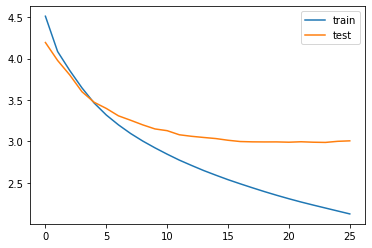

In [101]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [102]:
# 테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둠
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [103]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [104]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [113]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기

In [118]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence

In [119]:
# 테스트 데이터 약 10개의 샘플에 대해서 실제 요약과 예측된 요약을 비교
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : punjabi singer said exist world anymore people become towards constantly creating basis religion gender added singer said people realise everyone free whatever religion want treat fellow humans love respect 
실제 요약 : does not singer 
예측 요약 :  am not in wood


원문 : residents swiss village set vote initiative offering money non residents willing live years new residents would paid per child per adult houses people residents moving away large numbers past years 
실제 요약 : swiss village may pay people over lakh to move there 
예측 요약 :  village to be launched in


원문 : pakistan prime minister imran khan asked media give government three months criticising performance free criticise scared criticism helps address issues added khan said cabinet members could basis performance 
실제 요약 : give us months us pak pm imran khan 
예측 요약 :  pak pm imran khan imran khan


원문 : brazilian football club player repeatedly punched ball boy celebrated goal rival team result attack ball boy seen blood nose pla

## Step 5. Summa를 이용해서 추출적 요약해보기

### 데이터 다운로드하기

In [120]:
import requests
from summa.summarizer import summarize

In [121]:
# 테스트 데이터 약 5개의 샘플에 대해서 실제 요약/ 예측된 요약/ 추출적 요약 비교
for i in range(50, 55):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("추출 요약1 :", summarize(seq2text(encoder_input_test[i]), ratio=0.3))  # 원문의 0.3% 요약문으로 선택되는 문장의 개수 줄이기
    print("추출 요약2 :", summarize(seq2text(encoder_input_test[i]), ratio=0.3, split=True ))  # 리스트로 출력하고 싶다면 'split=True'
    print("추출 요약3 :", summarize(seq2text(encoder_input_test[i]), words=9 ))  # 단어 9개만 출력되어 요약하도록 설정
    print("\n")

원문 : punjabi singer said exist world anymore people become towards constantly creating basis religion gender added singer said people realise everyone free whatever religion want treat fellow humans love respect 
실제 요약 : does not singer 
예측 요약 :  am not in wood
추출 요약1 : 
추출 요약2 : []
추출 요약3 : 


원문 : residents swiss village set vote initiative offering money non residents willing live years new residents would paid per child per adult houses people residents moving away large numbers past years 
실제 요약 : swiss village may pay people over lakh to move there 
예측 요약 :  village to be launched in
추출 요약1 : 
추출 요약2 : []
추출 요약3 : 


원문 : pakistan prime minister imran khan asked media give government three months criticising performance free criticise scared criticism helps address issues added khan said cabinet members could basis performance 
실제 요약 : give us months us pak pm imran khan 
예측 요약 :  pak pm imran khan imran khan
추출 요약1 : 
추출 요약2 : []
추출 요약3 : 


원문 : brazilian football club player r